# $d$-separation

$d$-separation is a key concept in causal inference. 

*Why is d-separation important?* I have to answer this question better for myself, as I don't have a good way of putting it in my own words. What I am quite sure of, though, is that checking for $d$-separation is very helpful for inferring causal structures from observational data.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import networkx as nx
from custom import draw_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To get into $d$-separation, we first have to understand paths and blocked paths.

One thing that I didn't grok immediately when reading Judea Pearl's book on Causality was that the difference between a path and a causal path. A path is just any undirected connection between variables; a directed path, on the other hand, has to follow the directions on the edges.

This notebook is going to be structured as a hybrid between "my notes from Jonas Peters' lecture series" and "an exercise in implementing algorithms" related to $d$-separation and inferring causal structures from observational data (under certain assumptions).

Let's say we have the following causal structure (ignore the coefficients for the moment)

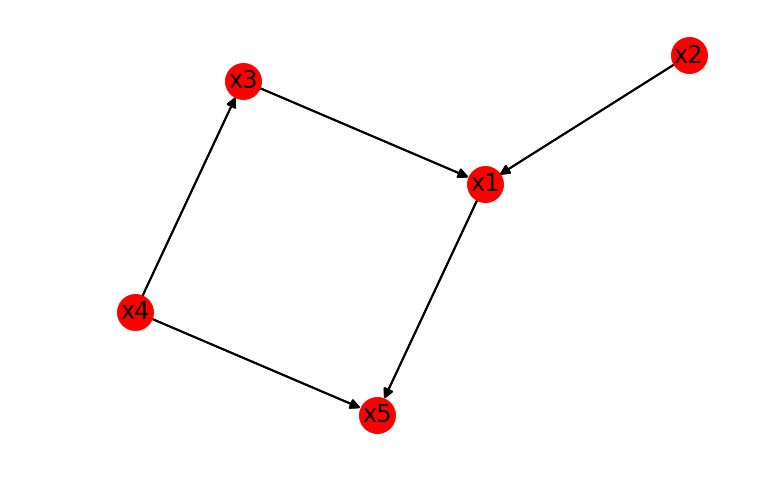

In [24]:
G = nx.DiGraph()
G.add_edge('x2', 'x1')
G.add_edge('x3', 'x1')
G.add_edge('x4', 'x3')
G.add_edge('x4', 'x5')
G.add_edge('x1', 'x5')
draw_graph(G)

There are some definitions that we have to get clear with.

- **Path:** Convert the graph to an undirected graph. Then ask if there is a connection between the two nodes or not.
- **Directed Path:** Follow the arrows!
- **V-structure:** An example in the above graph is $x_1$: it has two parents, $x_3$ and $x_2$ which are not connected by an arrow to each other.

From this, we then get to the definition of $d$-separation: Two nodes $x_i$ and $x_j$ are $d$-separated by the node set $S$ if all paths between $x_i$ and $x_j$ are blocked by the node set $S$.

We also call node set $S$ the "conditioning set".

There are three rules to determine this. For each node $n$ in $S$, we check whether it looks like the following:

1. $\rightarrow n \rightarrow$, where $n$ is in the conditioning set $S$,
1. $\leftarrow n \rightarrow$, where $n$ is in the conditioning set $S$
1. $\rightarrow n \leftarrow$, where $n$ is **not** in the conditioning set $S$

(recall: don't follow the arrows, as we're not referring to directed paths)

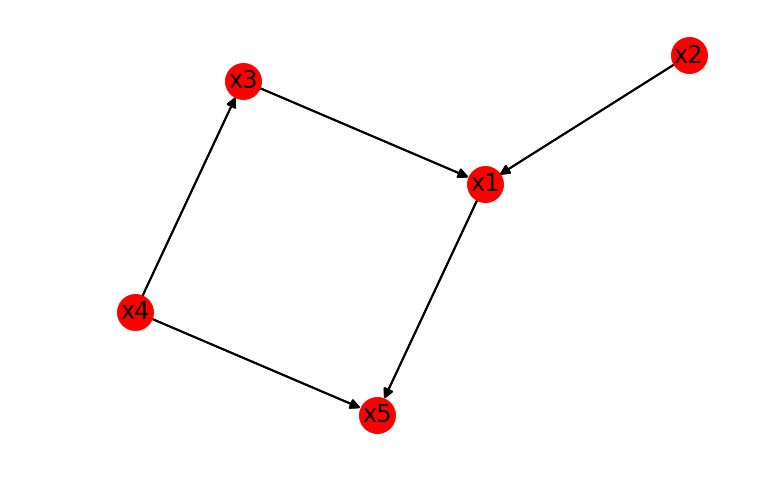

In [25]:
draw_graph(G)

## Example 1

Anchoring ourself in the above example, let's ask if $x_2$ and $x_5$ are $d$-separated by the node set $S = \{x_1, x_4\}$. 

1. $x_1$ lies on the path from $x_2$ to $x_5$, and looks like Rule \#1.
1. $x_4$ lies on the path from $x_2$ to $x_5$ (the path is $x_2 \rightarrow x_1 \leftarrow x_3 \leftarrow x_4 \rightarrow x_5$), and looks like Rule \#2.

Therefore, by rules \#1 and \#2, $\{x_2, x_5\}$ are $d$-separated by $S = \{x_1, x_4\}$.

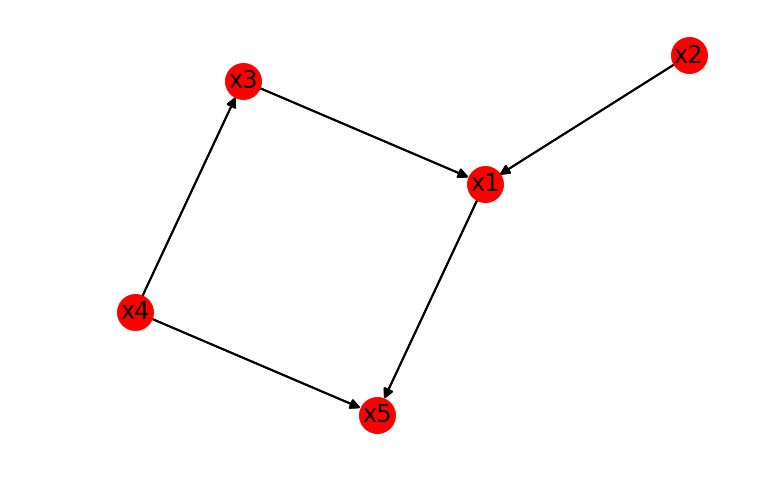

In [26]:
draw_graph(G)

## Example 2

Let's ask if $x_1$ and $x_4$ are $d$-separated by the node set $S = \{x_2, x_3\}$.

1. $x_2$ does not lie on a causal path from $x_1$ to $x_4$.
1. $x_3$ lies on a causal path from $x_1$ to $x_4$ (the path is $x_1 \leftarrow x_3 \leftarrow x_4$), and looks like Rule \#1.
1. The other path from $x_1$ to $x_4$ is $x_1 \rightarrow x_5 \leftarrow x_4$, and $x_5$ is not in the node set $S$, therefore this looks like Rule \#3.

Therefore, by rules \#1 and \#3, $\{x_1, x_4\}$ are $d$-separated by $S = \{x_2, x_3\}$.

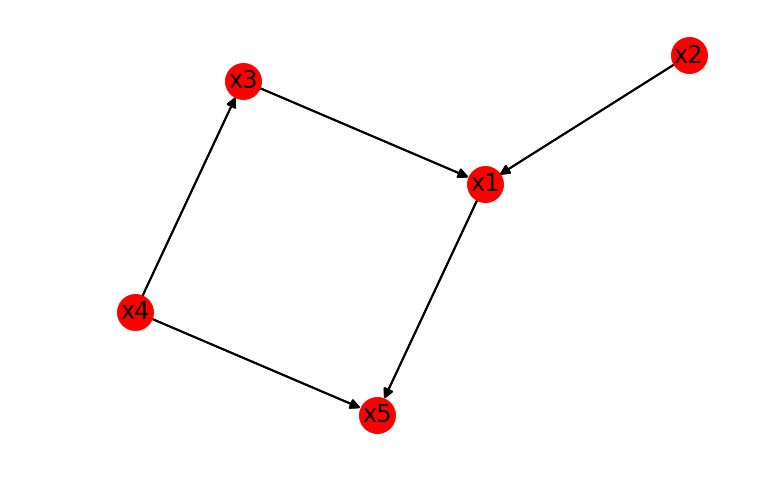

In [27]:
draw_graph(G)

## Example 3

Finally, let's ask if $x_2$ and $x_4$ are $d$-separated by the node set $S = \{\}$.

There are two sets of paths to go from $x_2$ to $x_4$:

1. $x_2 \rightarrow x_1 \rightarrow x_5 \leftarrow x_4$
1. $x_2 \rightarrow x_1 \leftarrow x_3 \leftarrow x_4$

In both cases, $x_1$ is not in node set $S=\{\}$, and looks like Rule \#3.

Therefore, by rule \#3, $x_2$ and $x_4$ are $d$-separated by $S = \{\}$.

# Algorithm

From the above examples, I think I have a way of writing an algorithm that can automatically check for $d$-separation.

Firstly, we have to define the three rules as functions.

In [56]:
def rule1(n, S, G, path):
    """
    Tells us if a node in the graph G satisfies
    blocking rule 1 in the causal path provided.
    
    Blocking rule 1 is:
    
        -> n ->
        
    Where n is a member of S.
    
    :param n: A node in graph G.
    :param S: The conditioning node set.
    :param G: A NetworkX graph.
    :param path: The causal path of interest.
    """
    G_sub = G.subgraph(path)
    in_conditioning_set = n in S
    has_in_edges = len(list(G_sub.in_edges(n))) == 1
    has_out_edges = len(list(G_sub.out_edges(n))) == 1
    return in_conditioning_set and has_in_edges and has_out_edges

def rule2(n, S, G, path):
    """
    Tells us if a node in the graph G satisfies
    blocking rule 2 in the causal path provided.
    
    Blocking rule 2 is:
    
        <- n ->
        
    Where n is a member of S.
    
    :param n: A node in graph G.
    :param S: The conditioning node set.
    :param G: A NetworkX graph.
    :param path: The causal path of interest.
    """
    G_sub = G.subgraph(path)
    in_conditioning_set = n in S
    has_out_edges = len(list(G_sub.out_edges(n))) == 2
    return in_conditioning_set and has_out_edges

def rule3(n, S, G, path):
    """
    Tells us if a node in the graph G satisfies
    blocking rule 3 in the causal path provided.
    
    Blocking rule 3 is:
    
        -> n <-
        
    Where n is NOT a member of S.
    
    :param n: A node in graph G.
    :param S: The conditioning node set.
    :param G: A NetworkX graph.
    :param path: The causal path of interest.
    """
    G_sub = G.subgraph(path)
    in_conditioning_set = n in S
    has_in_edges = len(list(G_sub.in_edges(n))) == 2
    return not in_conditioning_set and has_in_edges

Then, we define the $d$-separation algorithm:

In [98]:
def d_separation(n1, n2, S, G: nx.DiGraph):
    """
    Checks whether nodes n1 and n2 are d-separated by the set S.
    
    :param n1: A node in the graph G.
    :param n2: A node in the graph G.
    :param S: The conditioning set of interest.
    :param G: A NetworkX directed graph.
    :returns: (bool) dsep.
    """
    # Defensive programming checks.
    def error(n):
        """Custom error message for assertions below."""
        return f"node {n} not in graph G"
    
    assert n1 in G.nodes(), error(n1)
    assert n2 in G.nodes(), error(n1)
    for n in S:
        assert n in G.nodes(), error(n1)
    
    # First, we hold an undirected copy of the graph.
    Gpath = G.to_undirected()
    
    # Next, we check whether there is a path from node n1 to n2.
    assert nx.has_path(Gpath, n1, n2)
    
    # Next, we iterate over each path between n1 and n2, and check for the three rules.
    #
    # Any one of the three rules has to be fulfilled on a path for the path to be
    # blocked by the set S.
    #
    # However, blocking must occur on all paths, otherwise, the two nodes n1 and n2 are
    # not d-separated.
    paths_blocked = []
    for path in nx.all_simple_paths(G.to_undirected(), n1, n2):
        is_blocked = False
        for node in path:
            if node is not n1 and node is not n2:
                pass1 = rule1(node, S, G, path) 
                pass2 = rule2(node, S, G, path)
                pass3 = rule3(node, S, G, path)
                if (pass1 or pass2 or pass3):
                    is_blocked = True
        paths_blocked.append(is_blocked)
    return all(paths_blocked)
    

Finally, let's run the test cases.

From the examples above, $x_2$ and $x_5$ are $d$-separated by $\{x_1, x_4\}$:

In [105]:
d_separation('x2', 'x5', set(['x1', 'x4']), G)

True

Also, $x_1$ and $x_4$ are $d$-separated by $\{x_2, x_3\}$:

In [106]:
d_separation('x1', 'x4', set(['x2', 'x3']), G)

True

Finally, $x_2$ and $x_4$ are $d$-separated by $\{\}$ (an empty set of nodes):

In [107]:
d_separation('x2', 'x4', set([]), G)

True

Woohoo! 

The hard part about doing this manually is that it's difficult to manually enumerate all simple paths between two nodes on a graph. Like, tracing it and keeping it in memory is difficult. But implementing the rules as an algorithm helps.

A few more tests: Edges should not be $d$-separated.

In [108]:
for n1, n2 in G.edges():
    assert not d_separation(n1, n2, set([]), G)

So, why is this important? It allows us to state a thing called the "Markov condition":

> The joint probability distribution $P$ between two variables $x_i$ and $x_j$ is Markov w.r.t. the graph $G$ if, for the conditioning set $S$:
>
> $x_i$ and $x_j$ are $d$-separated by $S$ in $G$.
>
> $\implies$ (implies) $x_i$ is conditionally independent of $x_j$, conditioned on $S$.